In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

register_matplotlib_converters()

import xgboost
from xgboost import XGBRegressor
# read data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
df = pd.read_csv('data/IDA2.csv')
df.rename(columns={'DeliveryDateTime': 'date', 'Price': 'price_IDA2'}, inplace=True)

df.index = df['date']

df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert("Europe/Paris")

df.index = pd.DatetimeIndex(df.index).to_period('15min')
df.drop(['date'], axis=1, inplace=True)
df.sort_index(inplace=True)
df.tail()

C:\Users\patri\AppData\Local\Temp\ipykernel_21568\1223552229.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index = pd.DatetimeIndex(df.index).to_period('15min')


,price_IDA2
date,
2024-11-03 22:45,102.85
2024-11-03 23:00,108.21
2024-11-03 23:15,97.69
2024-11-03 23:30,101.00
2024-11-03 23:45,91.62


In [ ]:
df.describe()

,price_IDA2
count,13244.000000
mean,94.390116
std,146.416787
min,-99.380000
25%,59.427500
50%,87.670000
75%,113.907500
max,5349.500000


In [ ]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [ ]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [ ]:
test = series_to_supervised(df['price_IDA2'].to_list(), 96, 1)
test

array([[137.9 , 113.89,  86.51, ...,  67.77,  54.04,  80.93],
       [113.89,  86.51,  83.8 , ...,  54.04,  80.93,  73.73],
       [ 86.51,  83.8 ,  78.6 , ...,  80.93,  73.73,  61.94],
       ...,
       [105.99, 106.71,  91.96, ..., 102.85, 108.21,  97.69],
       [106.71,  91.96, 113.71, ..., 108.21,  97.69, 101.  ],
       [ 91.96, 113.71,  97.1 , ...,  97.69, 101.  ,  91.62]])

In [ ]:
mae, y, yhat = walk_forward_validation(test, 4*24)
print('MAE: %.3f' % mae)

>expected=113.7, predicted=112.4
>expected=97.1, predicted=105.4
>expected=90.2, predicted=99.0
>expected=81.4, predicted=88.8
>expected=106.6, predicted=111.5
>expected=92.9, predicted=93.3
>expected=85.1, predicted=84.2


KeyboardInterrupt: 

<Axes: >

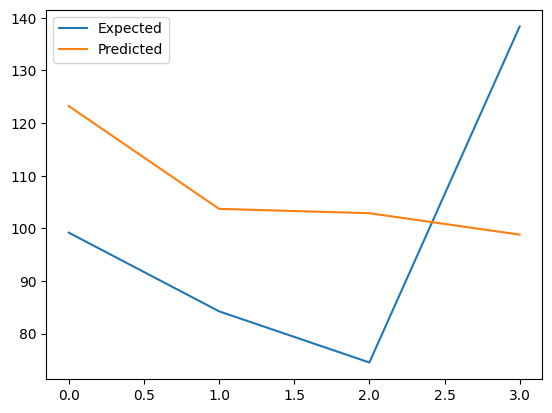

In [ ]:
compare = pd.DataFrame({'Expected': y, 'Predicted': yhat})
compare.plot()

<Axes: >

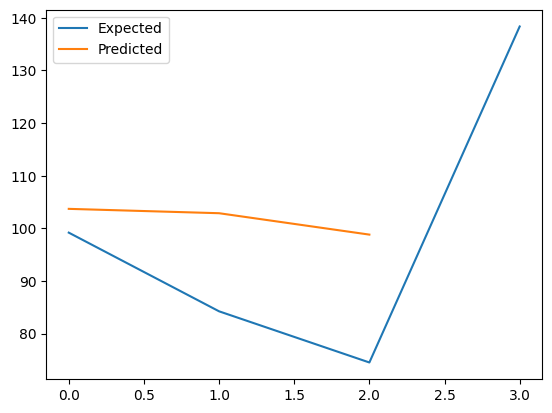

In [ ]:
compare2 = compare.copy()
compare2['Predicted'] = compare2['Predicted'].shift(-1)
compare2.plot()

In [ ]:
compare2

,Expected,Predicted
0,138.35,125.889999
1,100.65,101.885086
2,80.00,88.465652
3,84.99,84.374199
4,121.00,114.509895
...,...,...
91,102.07,100.698090
92,114.78,111.552589
93,105.99,106.186737
94,106.71,95.737221


In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

def compare_rmse(real, pred):
	rms = np.sqrt(root_mean_squared_error(compare2['Expected'].head(95), compare2['Predicted'].head(95)))
	mape = np.sqrt(mean_absolute_percentage_error(compare2['Expected'].head(95), compare2['Predicted'].head(95)))
	print("RMSE: %.3f, MAPE: %.3f" % (rms, mape))

In [ ]:
compare_rmse(compare['Expected'], compare['Predicted'])
compare_rmse(compare2['Expected'].head(95), compare2['Predicted'].head(95))

RMSE: 2.671, MAPE: 0.204
RMSE: 2.671, MAPE: 0.204
